##### Library Import

In [19]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join

# Data manipulation
import pandas as pd 
import numpy as np

# Machine learning
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

##### Data Download 
###### from https://docs.google.com/uc?export=download&id=1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0

In [20]:
train_data_path = './data/train.csv'
test_data_path = './data/test.csv'

data = pd.read_csv(train_data_path)
sub = pd.read_csv(test_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


##### Delete 'price' Label From 'data'

In [21]:
y = data['price']
data = data.drop('price', axis=1)
print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


##### Combine 'data' & 'sub'

In [22]:
train_len = len(data)
data = pd.concat((data, sub))
print(len(data))
data.head()

21503


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  object 
 2   bedrooms       21503 non-null  int64  
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  int64  
 5   sqft_lot       21503 non-null  int64  
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  int64  
 12  sqft_basement  21503 non-null  int64  
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  lat            21503 non-null  float64
 17  long           21503 non-null  float64
 18  sqft_li

##### Count NULL

In [24]:
missing = data.isna().sum()
print(missing)

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [25]:
missing/data.shape[0]

id               0.0
date             0.0
bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
waterfront       0.0
view             0.0
condition        0.0
grade            0.0
sqft_above       0.0
sqft_basement    0.0
yr_built         0.0
yr_renovated     0.0
zipcode          0.0
lat              0.0
long             0.0
sqft_living15    0.0
sqft_lot15       0.0
dtype: float64

In [26]:
data.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21503.000000,21503.000000,21503.000000,21503.000000,2.150300e+04,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,10751.000000,3.371762,2.116042,2081.441334,1.511715e+04,1.495140,0.007580,0.234618,3.409710,7.659164,1789.765986,291.675348,1971.055016,84.741943,98077.897968,47.560121,-122.213786,1987.242664,12774.529089
std,6207.525755,0.930026,0.770018,918.669624,4.147591e+04,0.540183,0.086737,0.766453,0.650066,1.174422,828.481664,442.645882,29.372398,402.452836,53.489890,0.138615,0.140833,685.579479,27334.995914
min,0.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,5375.500000,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,10751.000000,3.000000,2.250000,1914.000000,7.616000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,16126.500000,4.000000,2.500000,2550.000000,1.068600e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98117.000000,47.678100,-122.125000,2370.000000,10085.000000
max,21502.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


##### Visualize 'data' using missingno Library

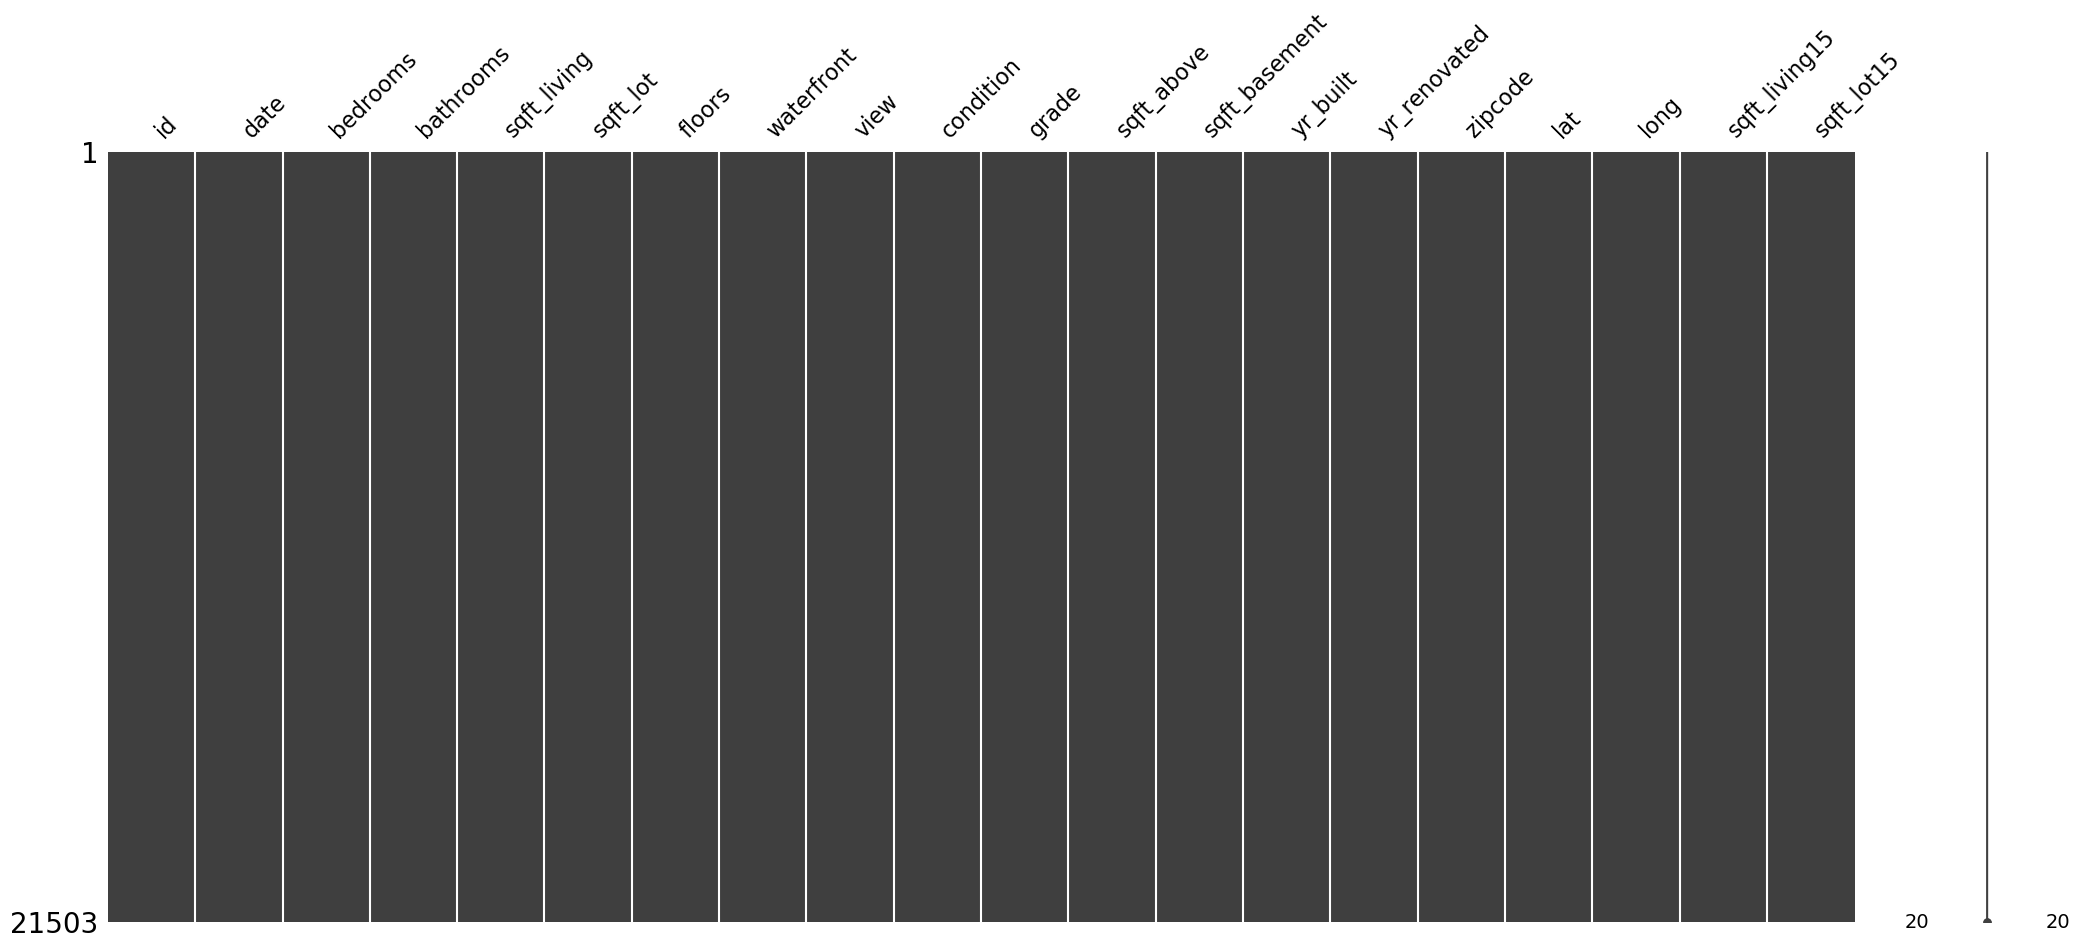

In [27]:
import missingno as msno
msno.matrix(df = data)
plt.show()

##### Delete 'id' Column From 'data'

In [28]:
sub_id = data['id'][train_len:]
del data['id']
print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


##### Edit 'date' Column From 'data'

In [29]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


##### Determine & Transform Distribution

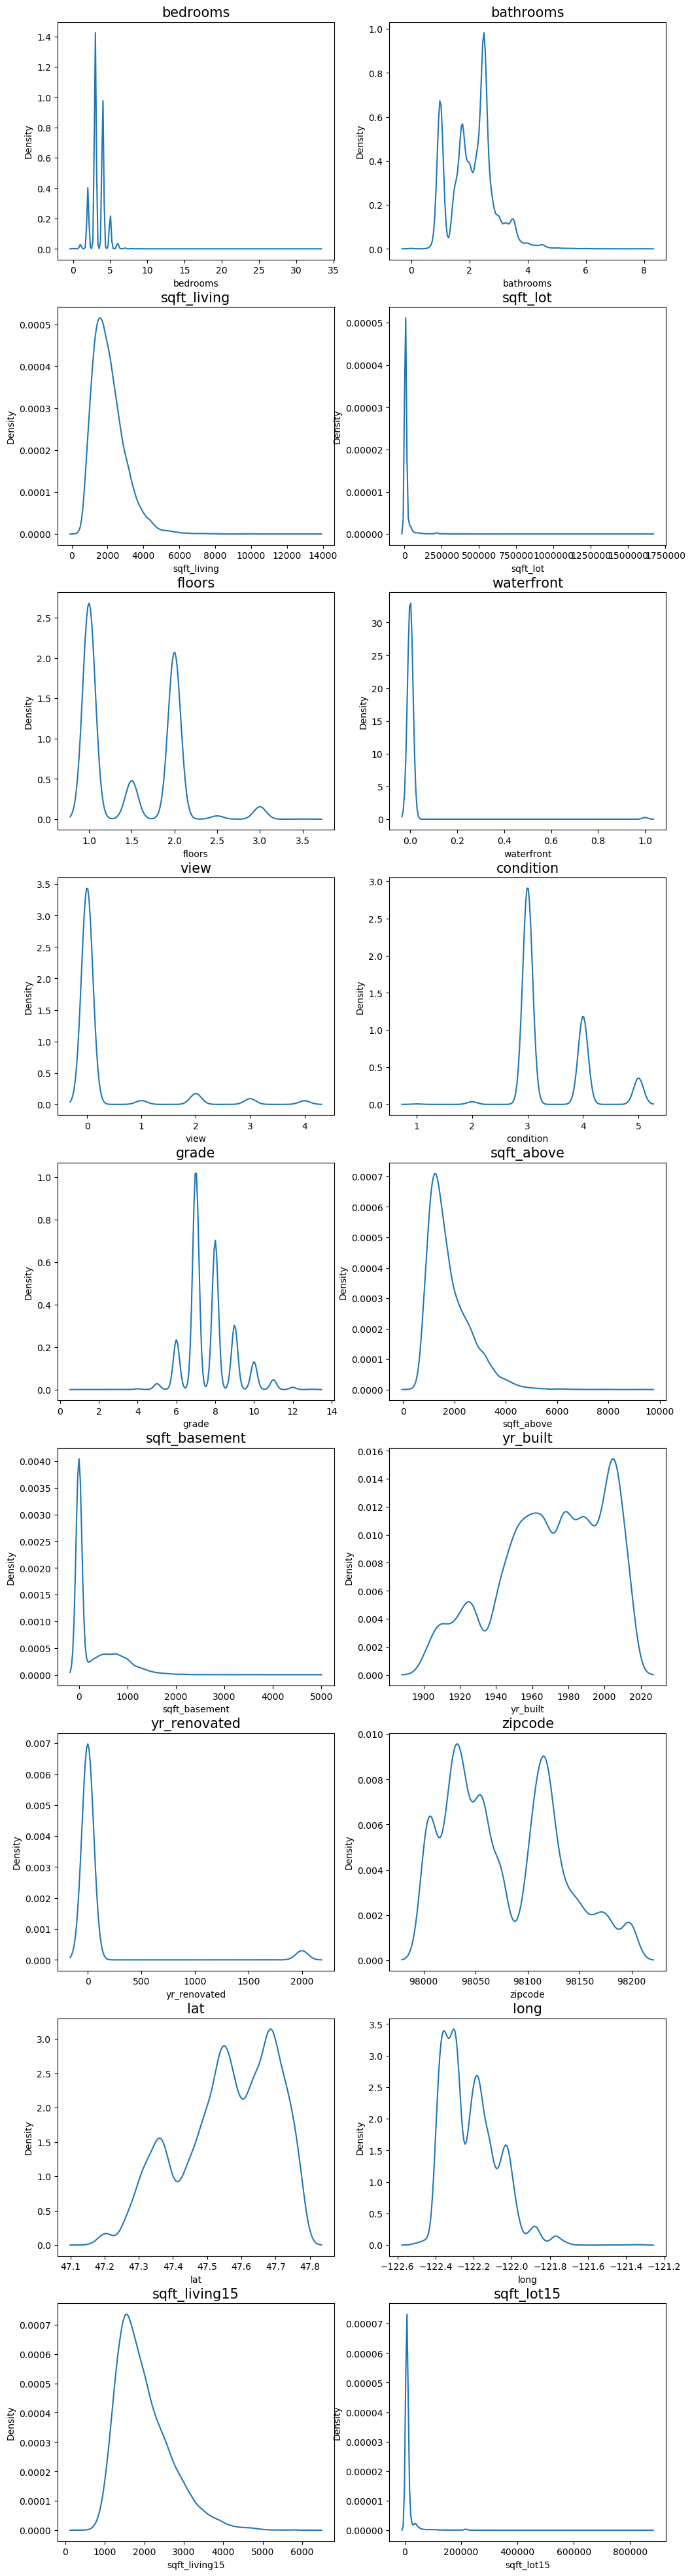

In [30]:
fig, ax = plt.subplots(9, 2, figsize=(12,50))

count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

##### Log-scaling

In [31]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c])

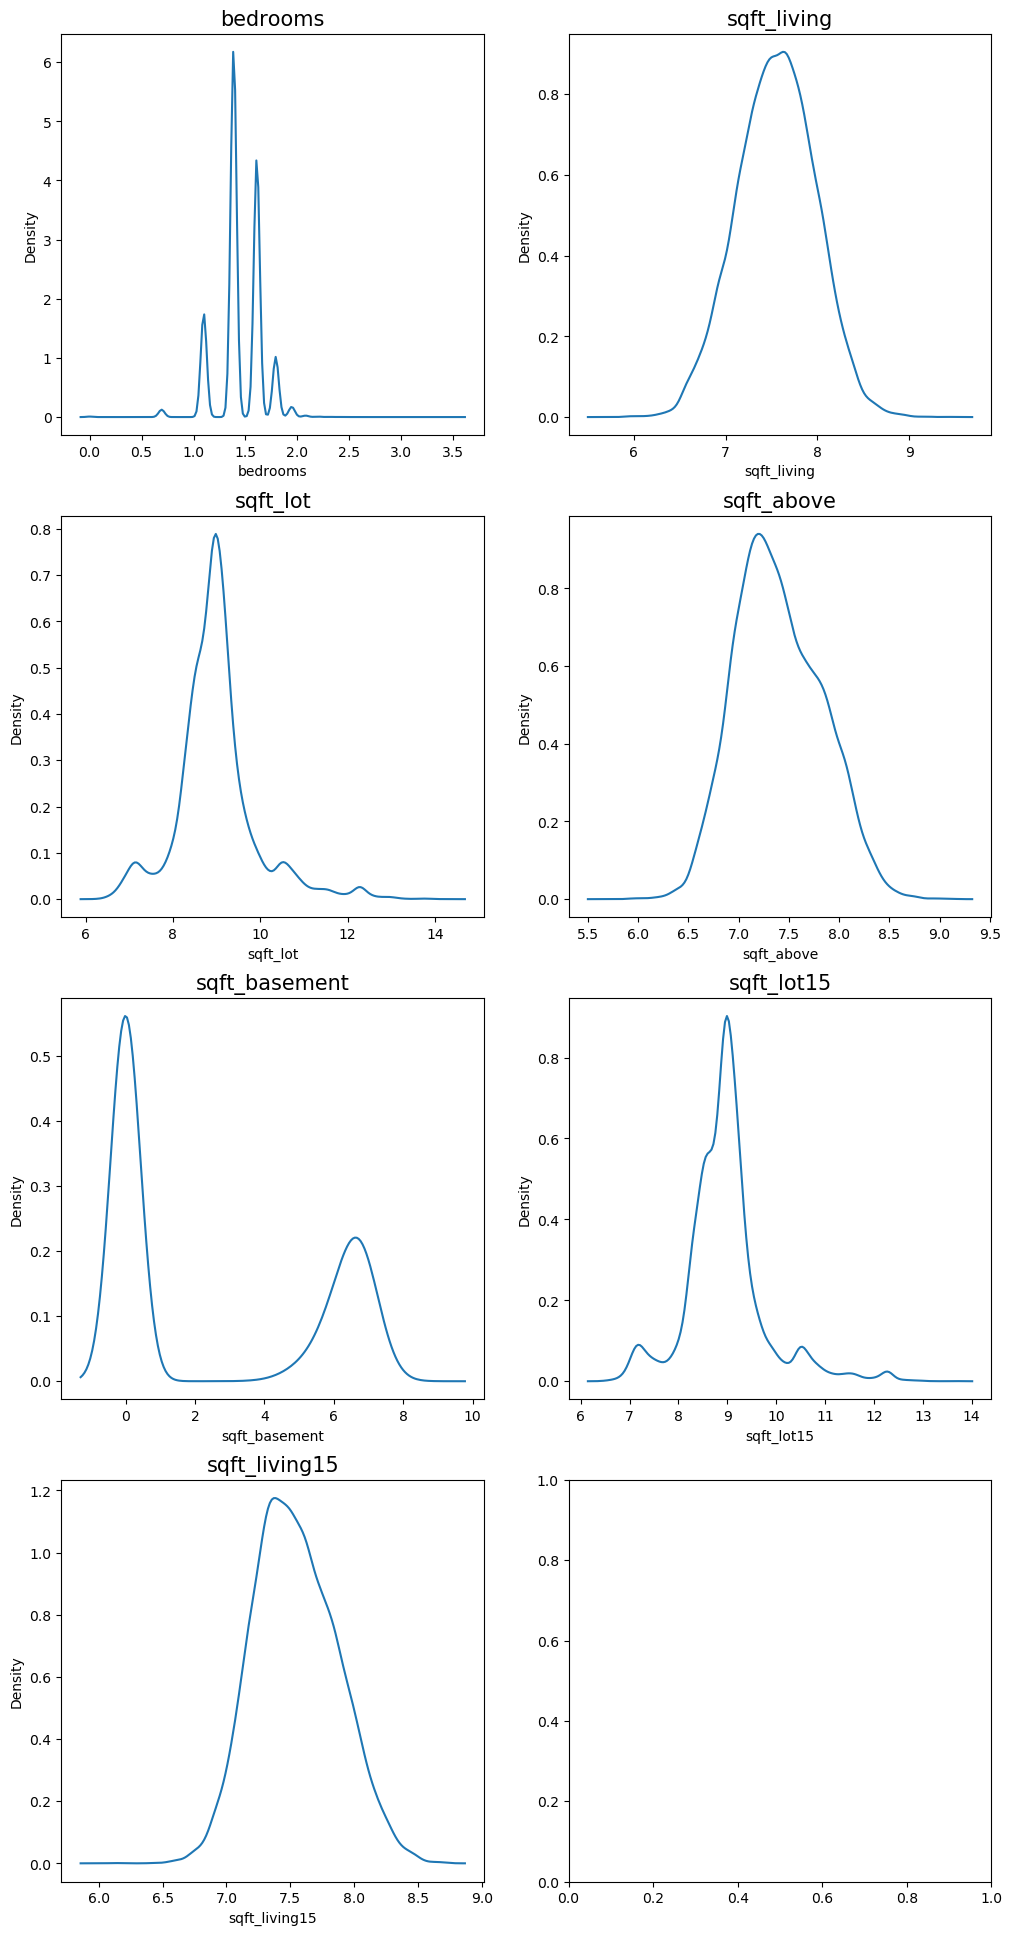

In [32]:
fig, ax = plt.subplots(4, 2, figsize=(12,24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

##### Separate Data

In [ ]:
x = data.iloc[:train_len, :]
sub = data.iloc[train_len:, :]

print(x.shape)
print(sub.shape)